<a href="https://colab.research.google.com/github/ankiitb/AE4423-Airline_Planning_and_Optimisation/blob/main/Fleet_transition_pb_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pyomo
!pip install gurobipy
!apt-get install -y -qq glpk-utils
import pyomo.environ as pyo
!apt-get install -y -qq coinor-cbc
#'cbc', executable='/usr/bin/cbc'

In [ ]:
# @title CBC MODEL
import pandas as pd
from pyomo.environ import *
from math import ceil

# Read in the CSV files
demand_df = pd.read_csv('demand.csv')
vehicles_df = pd.read_csv('vehicles.csv')
vehicles_fuels_df = pd.read_csv('vehicles_fuels.csv')
fuels_df = pd.read_csv('fuels.csv')
carbon_emissions_df = pd.read_csv('carbon_emissions.csv')

# Create a model
model = ConcreteModel()

# Define sets
model.Years = RangeSet(2023, 2038)
model.VehicleTypes = Set(initialize=vehicles_df['ID'].unique())
model.SizeBuckets = Set(initialize=['S1', 'S2', 'S3', 'S4'])
model.DistanceBuckets = Set(initialize=['D1', 'D2', 'D3', 'D4'])
model.Fuels = Set(initialize=fuels_df['Fuel'].unique())

# Define parameters
def purchase_cost_init(model, vehicle):
    row = vehicles_df[vehicles_df['ID'] == vehicle]
    if not row.empty:
        return row['Cost ($)'].values[0]
    else:
        return 0

model.PurchaseCost = Param(model.VehicleTypes, initialize=purchase_cost_init)

def yearly_range_init(model, vehicle):
    row = vehicles_df[vehicles_df['ID'] == vehicle]
    if not row.empty:
        return row['Yearly range (km)'].values[0]
    else:
        return 0

model.YearlyRange = Param(model.VehicleTypes, initialize=yearly_range_init)

def fuel_consumption_init(model, vehicle, fuel):
    row = vehicles_fuels_df[(vehicles_fuels_df['ID'] == vehicle) & (vehicles_fuels_df['Fuel'] == fuel)]
    if not row.empty:
        return row['Consumption (unit_fuel/km)'].values[0]
    else:
        return 0

model.FuelConsumption = Param(model.VehicleTypes, model.Fuels, initialize=fuel_consumption_init)

def fuel_cost_init(model, year, fuel):
    row = fuels_df[(fuels_df['Year'] == year) & (fuels_df['Fuel'] == fuel)]
    if not row.empty:
        return row['Cost ($/unit_fuel)'].values[0]
    else:
        return 0

model.FuelCost = Param(model.Years, model.Fuels, initialize=fuel_cost_init)

def carbon_emission_limit_init(model, year):
    row = carbon_emissions_df[carbon_emissions_df['Year'] == year]
    if not row.empty:
        return row['Carbon emission CO2/kg'].values[0]
    else:
        return 0

model.CarbonEmissionLimit = Param(model.Years, initialize=carbon_emission_limit_init)

def carbon_emission_per_unit_init(model, fuel):
    row = fuels_df[fuels_df['Fuel'] == fuel]
    if not row.empty:
        return row['Emissions (CO2/unit_fuel)'].values[0]
    else:
        return 0

model.CarbonEmissionPerUnit = Param(model.Fuels, initialize=carbon_emission_per_unit_init)

def demand_init(model, year, size, distance):
    row = demand_df[(demand_df['Year'] == year) & (demand_df['Size'] == size) & (demand_df['Distance'] == distance)]
    if not row.empty:
        return row['Demand (km)'].values[0]
    else:
        return 0

model.Demand = Param(model.Years, model.SizeBuckets, model.DistanceBuckets, initialize=demand_init)

def available_fuel_init(model, vehicle, fuel):
    row = vehicles_fuels_df[(vehicles_fuels_df['ID'] == vehicle) & (vehicles_fuels_df['Fuel'] == fuel)]
    if not row.empty:
        return 1
    else:
        return 0

model.AvailableFuel = Param(model.VehicleTypes, model.Fuels, initialize=available_fuel_init, within=Binary)

# Define insurance and maintenance cost parameters as percentages of purchase cost
insurance_cost_percentage = {
    1: 0.05, 2: 0.06, 3: 0.07, 4: 0.08, 5: 0.09,
    6: 0.10, 7: 0.11, 8: 0.12, 9: 0.13, 10: 0.14
}
maintenance_cost_percentage = {
    1: 0.01, 2: 0.03, 3: 0.05, 4: 0.07, 5: 0.09,
    6: 0.11, 7: 0.13, 8: 0.15, 9: 0.17, 10: 0.19
}

resale_percentage = {
    1: 0.9, 2: 0.8, 3: 0.7, 4: 0.6, 5: 0.5,
    6: 0.4, 7: 0.3, 8: 0.3, 9: 0.3, 10: 0.3
}

# Decision variables
model.NumVehiclesPurchased = Var(model.Years, model.VehicleTypes, within=NonNegativeIntegers)
model.NumVehiclesUsed = Var(model.Years, model.VehicleTypes, model.Fuels, model.DistanceBuckets, within=NonNegativeIntegers)
model.NumVehiclesSold = Var(model.Years, model.VehicleTypes, within=NonNegativeIntegers)
model.Inventory = Var(model.Years, model.VehicleTypes, within=NonNegativeIntegers)

def total_cost_rule(model):
    purchase_cost = sum(model.PurchaseCost[vt] * model.NumVehiclesPurchased[yr, vt] for yr in model.Years for vt in model.VehicleTypes)
    fuel_cost = sum(model.NumVehiclesUsed[yr, vt, f, db] * model.YearlyRange[vt] * model.FuelConsumption[vt, f] * model.FuelCost[yr, f] for yr in model.Years for vt in model.VehicleTypes for f in model.Fuels for db in model.DistanceBuckets)
    # Calculate insurance and maintenance costs for all vehicles in the inventory each year
    insurance_cost = sum(
        model.Inventory[yr, vt] * model.PurchaseCost[vt] * insurance_cost_percentage[min(10, yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0])+1)]
        for yr in model.Years for vt in model.VehicleTypes
        if yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0]) >= 0
    )
    maintenance_cost = sum(
        model.Inventory[yr, vt] * model.PurchaseCost[vt] * maintenance_cost_percentage[min(10, yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0])+1)]
        for yr in model.Years for vt in model.VehicleTypes
        if yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0]) >= 0
    )
    resale_value = sum(
        model.NumVehiclesSold[yr, vt] * model.PurchaseCost[vt] * resale_percentage[min(10, yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0])+1)]
        for yr in model.Years for vt in model.VehicleTypes
        if yr - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0]) >= 0
    )
    residual_value = sum(
        model.Inventory[2038, vt] * model.PurchaseCost[vt] * resale_percentage[min(10, 2038 - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0])+1)]
         for vt in model.VehicleTypes
        if 2038 - int(vehicles_df.loc[vehicles_df['ID'] == vt, 'Year'].values[0]) >= 0
    )
    return purchase_cost + fuel_cost + insurance_cost + maintenance_cost - resale_value - residual_value

model.TotalCost = Objective(rule=total_cost_rule, sense=minimize)


# Constraints

# 1. Meet the demand for each size-distance bucket every year.
def size_distance_demand_constraint_rule(model, yr, sb, db):
    return sum(model.NumVehiclesUsed[yr, vt, f, db] * model.YearlyRange[vt] for vt in model.VehicleTypes for f in model.Fuels if vehicles_df[vehicles_df['ID'] == vt]['Size'].values[0] == sb and vehicles_df[vehicles_df['ID'] == vt]['Distance'].values[0] >= db) >= model.Demand[yr, sb, db]
model.SizeDistanceDemandConstraint = Constraint(model.Years, model.SizeBuckets, model.DistanceBuckets, rule=size_distance_demand_constraint_rule)

# 2. Total carbon emitted by fleet operations each year should be within the respective year’s carbon emissions limits.
def carbon_emission_constraint_rule(model, yr):
    total_emission = sum(model.NumVehiclesUsed[yr, vt, f, db] * model.YearlyRange[vt] * model.FuelConsumption[vt, f] * model.CarbonEmissionPerUnit[f] for vt in model.VehicleTypes for f in model.Fuels for db in model.DistanceBuckets)
    return total_emission <= model.CarbonEmissionLimit[yr]
model.CarbonEmissionConstraint = Constraint(model.Years, rule=carbon_emission_constraint_rule)

# 3. Vehicles can only be bought in their introduction year.
def purchase_year_constraint_rule(model, yr, vt):
    purchase_year = vehicles_df[vehicles_df['ID'] == vt]['Year'].values[0]
    if yr != purchase_year:
        return model.NumVehiclesPurchased[yr, vt] == 0
    else:
        return Constraint.Skip
model.PurchaseYearConstraint = Constraint(model.Years, model.VehicleTypes, rule=purchase_year_constraint_rule)

# 4. Vehicles cannot be used beyond their 10-year lifespan.
def vehicle_life_constraint_rule(model, yr, vt):
    purchase_year = int(vehicles_df[vehicles_df['ID'] == vt]['Year'].values[0])
    if yr > purchase_year + 9:
        return (sum(model.NumVehiclesUsed[yr, vt, f, db] for f in model.Fuels for db in model.DistanceBuckets) + model.Inventory[yr, vt]) == 0
    else:
        return Constraint.Skip
model.VehicleLifeConstraint = Constraint(model.Years, model.VehicleTypes, rule=vehicle_life_constraint_rule)

# 5. At most 20% of the total vehicles in the fleet can be sold each year.
def sell_limit_constraint_rule(model, yr):
    if yr == 2023:
        total_vehicles_in_fleet = sum(model.NumVehiclesPurchased[yr, vt] for vt in model.VehicleTypes)
    else:
        total_vehicles_in_fleet = sum(model.Inventory[yr-1, vt] + model.NumVehiclesPurchased[yr, vt] for vt in model.VehicleTypes)
    return sum(model.NumVehiclesSold[yr, vt] for vt in model.VehicleTypes) <= 0.2 * total_vehicles_in_fleet
model.SellLimitConstraint = Constraint(model.Years, rule=sell_limit_constraint_rule)

# 6. Ensure that each vehicle uses only its available fuel types.
def fuel_availability_constraint_rule(model, yr, vt, f, db):
    return model.NumVehiclesUsed[yr, vt, f, db] <= model.AvailableFuel[vt, f] * sum(model.NumVehiclesPurchased[py, vt] for py in model.Years if py <= yr)
model.FuelAvailabilityConstraint = Constraint(model.Years, model.VehicleTypes, model.Fuels, model.DistanceBuckets, rule=fuel_availability_constraint_rule)

# 7. Ensure vehicles are not used once sold.
def usage_after_sell_constraint_rule(model, yr, vt):
    return sum(model.NumVehiclesUsed[yr, vt, f, db] for f in model.Fuels for db in model.DistanceBuckets) <= sum(model.NumVehiclesPurchased[py, vt] for py in model.Years if py <= yr) - sum(model.NumVehiclesSold[py, vt] for py in model.Years if py <= yr)
model.UsageAfterSellConstraint = Constraint(model.Years, model.VehicleTypes, rule=usage_after_sell_constraint_rule)

# 8. Limit vehicle usage to available fleet size
def usage_limit_constraint_rule(model, yr, vt):
    if yr == 2023:
        available_vehicles = model.NumVehiclesPurchased[yr, vt]
    else:
        available_vehicles = model.Inventory[yr - 1, vt] + model.NumVehiclesPurchased[yr, vt]

    total_used_vehicles = sum(model.NumVehiclesUsed[yr, vt, f, db] for f in model.Fuels for db in model.DistanceBuckets)
    return total_used_vehicles <= available_vehicles

model.UsageLimitConstraint = Constraint(model.Years, model.VehicleTypes, rule=usage_limit_constraint_rule)

# Inventory tracking
def inventory_balance_rule(model, yr, vt):
    if yr == 2023:
        return model.Inventory[yr, vt] == model.NumVehiclesPurchased[yr, vt] - model.NumVehiclesSold[yr, vt]
    else:
        return model.Inventory[yr, vt] == model.Inventory[yr - 1, vt] + model.NumVehiclesPurchased[yr, vt] - model.NumVehiclesSold[yr, vt]
model.InventoryBalance = Constraint(model.Years, model.VehicleTypes, rule=inventory_balance_rule)

# Solve the model
# solver = SolverFactory('glpk')
# solver.options['tmlim'] = 3600

solver = SolverFactory('cbc', executable='/usr/bin/cbc')
solver.options = {'sec': 3600, 'threads': 0, 'ratio': 0.001}
results = solver.solve(model, tee=True)
# Check for infeasibilities
if results.solver.termination_condition == TerminationCondition.infeasible:
    print("Model is infeasible")

solution = []
for yr in model.Years:
    for vt in model.VehicleTypes:
        # Capture vehicle purchases
        if model.NumVehiclesPurchased[yr, vt].value and model.NumVehiclesPurchased[yr, vt].value > 0:
            solution.append([yr, vt, ceil(model.NumVehiclesPurchased[yr, vt].value), 'Buy', '', '', 0])

        # Capture vehicle usage with associated fuels and distances
        for f in model.Fuels:
            for db in model.DistanceBuckets:
                if model.NumVehiclesUsed[yr, vt, f, db].value and model.NumVehiclesUsed[yr, vt, f, db].value > 0:
                    size = vehicles_df[vehicles_df['ID'] == vt]['Size'].values[0]
                    distance_per_vehicle = vehicles_df[(vehicles_df['ID'] == vt) & (vehicles_df['Size'] == size)]['Yearly range (km)'].values[0]
                    total_traveled = model.NumVehiclesUsed[yr, vt, f, db].value * distance_per_vehicle
                    solution.append([yr, vt, ceil(model.NumVehiclesUsed[yr, vt, f, db].value), 'Use', f, db, distance_per_vehicle])

        # Capture vehicle sales
        if model.NumVehiclesSold[yr, vt].value and model.NumVehiclesSold[yr, vt].value > 0:
            solution.append([yr, vt, ceil(model.NumVehiclesSold[yr, vt].value), 'Sell', '', '', 0])

output_df = pd.DataFrame(solution, columns=['Year', 'ID', 'Num_Vehicles', 'Type', 'Fuel', 'Distance_bucket', 'Distance_per_vehicle(km)'])

print(output_df)

In [ ]:
# @title CREATION OF SOLUTION FILE
solution = []
for yr in model.Years:
    for vt in model.VehicleTypes:
        # Capture vehicle purchases
        if model.NumVehiclesPurchased[yr, vt].value and model.NumVehiclesPurchased[yr, vt].value > 0:
            solution.append([yr, vt, ceil(model.NumVehiclesPurchased[yr, vt].value), 'Buy', '', '', 0])

        # Capture vehicle usage with associated fuels and distances
        for f in model.Fuels:
            for db in model.DistanceBuckets:
                if model.NumVehiclesUsed[yr, vt, f, db].value and model.NumVehiclesUsed[yr, vt, f, db].value > 0:
                    size = vehicles_df[vehicles_df['ID'] == vt]['Size'].values[0]
                    distance_per_vehicle = vehicles_df[(vehicles_df['ID'] == vt) & (vehicles_df['Size'] == size)]['Yearly range (km)'].values[0]
                    total_traveled = model.NumVehiclesUsed[yr, vt, f, db].value * distance_per_vehicle
                    solution.append([yr, vt, ceil(model.NumVehiclesUsed[yr, vt, f, db].value), 'Use', f, db, distance_per_vehicle])

        # Capture vehicle sales
        if model.NumVehiclesSold[yr, vt].value and model.NumVehiclesSold[yr, vt].value > 0:
            solution.append([yr, vt, ceil(model.NumVehiclesSold[yr, vt].value), 'Sell', '', '', 0])

output_df = pd.DataFrame(solution, columns=['Year', 'ID', 'Num_Vehicles', 'Type', 'Fuel', 'Distance_bucket', 'Distance_per_vehicle(km)'])
# output_df = pd.DataFrame(solution, columns=['Year', 'ID', 'Num_Vehicles', 'Type', 'Fuel', 'Distance_bucket', 'Distance_per_vehicle(km)'])
output_df["Num_Vehicles"] = output_df["Num_Vehicles"].astype(int)
output_df["Distance_per_vehicle(km)"] = output_df["Distance_per_vehicle(km)"].astype(float)
# output_df=output_df[output_df["Num_Vehicles"]>0]
output_df.to_csv('solution.csv', index=False)
output_df

,Year,ID,Num_Vehicles,Type,Fuel,Distance_bucket,Distance_per_vehicle(km)
0,2023,Diesel_S4_2023,1,Buy,,,0.0
1,2023,Diesel_S4_2023,1,Use,B20,D1,118000.0
2,2023,LNG_S1_2023,73,Buy,,,0.0
3,2023,LNG_S1_2023,9,Use,LNG,D1,102000.0
4,2023,LNG_S1_2023,26,Use,LNG,D2,102000.0
...,...,...,...,...,...,...,...
495,2038,BEV_S3_2036,11,Use,Electricity,D1,73000.0
496,2038,BEV_S3_2036,46,Use,Electricity,D2,73000.0
497,2038,BEV_S3_2037,19,Use,Electricity,D1,73000.0
498,2038,BEV_S3_2038,4,Buy,,,0.0


In [ ]:
# @title TOTAL COSTS

import pandas as pd

# Load the data
demand_df = pd.read_csv('demand.csv')
vehicles_df = pd.read_csv('vehicles.csv')
vehicles_fuels_df = pd.read_csv('vehicles_fuels.csv')
fuels_df = pd.read_csv('fuels.csv')
carbon_emissions_df = pd.read_csv('carbon_emissions.csv')
cost_profile_df = pd.read_csv('cost_profiles.csv')
output_df = pd.read_csv('solution.csv')
output_df = pd.read_csv('sample_submission.csv')


# Convert cost_profile_df to a dictionary
cost_profile_dict = {}
for _, row in cost_profile_df.iterrows():
    year = row['End of Year']
    cost_profile_dict[year] = {
        "resale_value": row['Resale Value %'] / 100,
        "insurance_cost": row['Insurance Cost %'] / 100,
        "maintenance_cost": row['Maintenance Cost %'] / 100
    }

def calculate_costs(output_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, start_year, end_year):
    yearly_costs = {}
    total_cost = 0

    total_purchase_cost = 0
    total_resale_value = 0
    total_fuel_cost = 0
    total_fuel_cost_upper = 0
    total_fuel_cost_lower = 0
    total_insurance_cost = 0
    total_maintenance_cost = 0

    # Initialize a dictionary to track the inventory of vehicles each year
    fleet_inventory = {year: {} for year in range(start_year, end_year + 1)}

    for year in range(start_year, end_year + 1):
        yearly_costs[year] = {
            'purchase_cost': 0,
            'fuel_cost': 0,
            'fuel_cost_upper': 0,
            'fuel_cost_lower': 0,
            'insurance_cost': 0,
            'maintenance_cost': 0,
            'resale_value': 0
        }

    for _, row in output_df.iterrows():
        year = row['Year']
        if year < start_year or year > end_year:
            continue

        vehicle_id = row['ID']
        num_vehicles = row['Num_Vehicles']
        action_type = row['Type']
        fuel_type = row.get('Fuel', None)
        distance_bucket = row.get('Distance_bucket', None)
        distance_per_vehicle = row.get('Distance_per_vehicle(km)', 0)

        vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
        purchase_year = int(vehicle_id.split('_')[-1])

        if action_type == 'Buy':
            yearly_purchase_cost = vehicle_cost * num_vehicles
            yearly_costs[year]['purchase_cost'] += yearly_purchase_cost
            total_purchase_cost += yearly_purchase_cost
            total_cost += yearly_purchase_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles

        elif action_type == 'Use':
            fuel_consumption = vehicles_fuels_df[(vehicles_fuels_df['ID'] == vehicle_id) & (vehicles_fuels_df['Fuel'] == fuel_type)]['Consumption (unit_fuel/km)'].values[0]
            fuel_info = fuels_df[(fuels_df['Year'] == year) & (fuels_df['Fuel'] == fuel_type)]
            fuel_unit_cost = fuel_info['Cost ($/unit_fuel)'].values[0]
            fuel_uncertainty = fuel_info['Cost Uncertainty (±%)'].values[0] / 100

            yearly_fuel_cost = fuel_consumption * distance_per_vehicle * fuel_unit_cost * num_vehicles
            yearly_fuel_cost_upper = yearly_fuel_cost * (1 + fuel_uncertainty)
            yearly_fuel_cost_lower = yearly_fuel_cost * (1 - fuel_uncertainty)

            yearly_costs[year]['fuel_cost'] += yearly_fuel_cost
            yearly_costs[year]['fuel_cost_upper'] += yearly_fuel_cost_upper
            yearly_costs[year]['fuel_cost_lower'] += yearly_fuel_cost_lower
            total_fuel_cost += yearly_fuel_cost
            total_fuel_cost_upper += yearly_fuel_cost_upper
            total_fuel_cost_lower += yearly_fuel_cost_lower
            total_cost += yearly_fuel_cost #yearly_fuel_cost_upper*1.0426

            age = year - purchase_year + 1
            if 1 <= age <= 10:
              yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
              yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
              total_insurance_cost += yearly_insurance_cost
              total_cost += yearly_insurance_cost

              yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
              yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
              total_maintenance_cost += yearly_maintenance_cost
              total_cost += yearly_maintenance_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles


        if action_type == 'Sell':
            age = year - purchase_year + 1
            if age > 0:
                # yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
                # yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
                # total_insurance_cost += yearly_insurance_cost
                # total_cost += yearly_insurance_cost

                # yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
                # yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
                # total_maintenance_cost += yearly_maintenance_cost
                # total_cost += yearly_maintenance_cost

                resale_value = vehicle_cost * cost_profile_dict[min(age, 10)]['resale_value'] * num_vehicles
                yearly_costs[year]['resale_value'] += resale_value
                total_resale_value += resale_value
                total_cost -= resale_value

            # Update the fleet inventory for the year
            if vehicle_id in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] -= num_vehicles

    # Calculate insurance and maintenance costs for all vehicles in the fleet
    # for year in range(start_year, end_year+1):
    #     for vehicle_id, num_vehicles in fleet_inventory[year].items():
    #         if num_vehicles > 0:
    #             vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
    #             purchase_year = int(vehicle_id.split('_')[-1])
    #             age = year - purchase_year + 1
    #             if 1 <= age <= 10:
    #                 yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
    #                 yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
    #                 total_insurance_cost += yearly_insurance_cost
    #                 total_cost += yearly_insurance_cost

    #                 yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
    #                 yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
    #                 total_maintenance_cost += yearly_maintenance_cost
    #                 total_cost += yearly_maintenance_cost

    # Sell all remaining vehicles at the end of the final year
    final_year = end_year
    for vehicle_id, num_vehicles in fleet_inventory[final_year].items():
        if num_vehicles > 0:
            vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
            age = final_year - int(vehicle_id.split('_')[-1]) + 1
            resale_value = vehicle_cost * cost_profile_dict[min(age, 10)]['resale_value'] * num_vehicles
            yearly_costs[final_year]['resale_value'] += resale_value
            total_resale_value += resale_value
            total_cost -= resale_value

    return fleet_inventory, yearly_costs, total_cost, total_purchase_cost, total_resale_value, total_fuel_cost, total_fuel_cost_upper, total_fuel_cost_lower, total_insurance_cost, total_maintenance_cost

def calculate_for_period(start_year, end_year):
    fleet_inventory, yearly_costs, total_cost, total_purchase_cost, total_resale_value, total_fuel_cost, total_fuel_cost_upper, total_fuel_cost_lower, total_insurance_cost, total_maintenance_cost = calculate_costs(output_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, start_year, end_year)

    # Print results with commas and dollar signs
    print(f"Year Range: {start_year} to {end_year}")
    print(f"Total Cost: ${total_cost:,.2f}")
    print(f"Total Purchase Cost: ${total_purchase_cost:,.2f}")
    print(f"Total Resale Value: ${total_resale_value:,.2f}")
    print(f"Total Fuel Cost: ${total_fuel_cost:,.2f}")
    print(f"Total Fuel Cost (Upper): ${total_fuel_cost_upper:,.2f}")
    print(f"Total Fuel Cost (Lower): ${total_fuel_cost_lower:,.2f}")
    print(f"Total Insurance Cost: ${total_insurance_cost:,.2f}")
    print(f"Total Maintenance Cost: ${total_maintenance_cost:,.2f}")
    print(f"Total I+M: ${total_insurance_cost + total_maintenance_cost:,.2f}")
    if end_year == 2038:
        print(f"Score Board: {(100 -( (70*total_cost)/172000000)):,.2f}")
    elif end_year == 2028:
        print(f"Score Board: {(100 -( (70*total_cost)/65000000)):,.2f}")
    print("\n")

    return fleet_inventory

fleet_inventory = calculate_for_period(2023, 2028)

fleet_inventory = calculate_for_period(2023, 2038)

Year Range: 2023 to 2028
Total Cost: $56,061,118.70
Total Purchase Cost: $54,815,444.00
Total Resale Value: $43,526,965.30
Total Fuel Cost: $26,269,124.38
Total Fuel Cost (Upper): $27,571,684.82
Total Fuel Cost (Lower): $24,966,563.94
Total Insurance Cost: $11,279,626.53
Total Maintenance Cost: $7,223,889.09
Total I+M: $18,503,515.62
Score Board: 39.63


Year Range: 2023 to 2038
Total Cost: $183,094,970.37
Total Purchase Cost: $148,381,278.00
Total Resale Value: $104,664,365.00
Total Fuel Cost: $58,971,731.21
Total Fuel Cost (Upper): $66,816,339.55
Total Fuel Cost (Lower): $51,127,122.87
Total Insurance Cost: $44,600,787.84
Total Maintenance Cost: $35,805,538.32
Total I+M: $80,406,326.16
Score Board: 25.48




```
LEADERBOARD 51.59:
Total Cost 2028: $88,423,663.65
Total Cost 2038: $247,211,956.60
```

```
LEADERBOARD 35.16520:
Total Cost 2028: $86,498,345.75
Total Cost 2038: $229,734,481.47

```

```
LEADERBOARD 34.82548:
Total Cost 2028: $86,835,545.43
Total Cost 2038: $230,045,967.45

```
```
LEADERBOARD 33.42163: (sample submission)
Total Cost 2028: $78,390,058.55
Total Cost 2038: $220,654,471.34

```



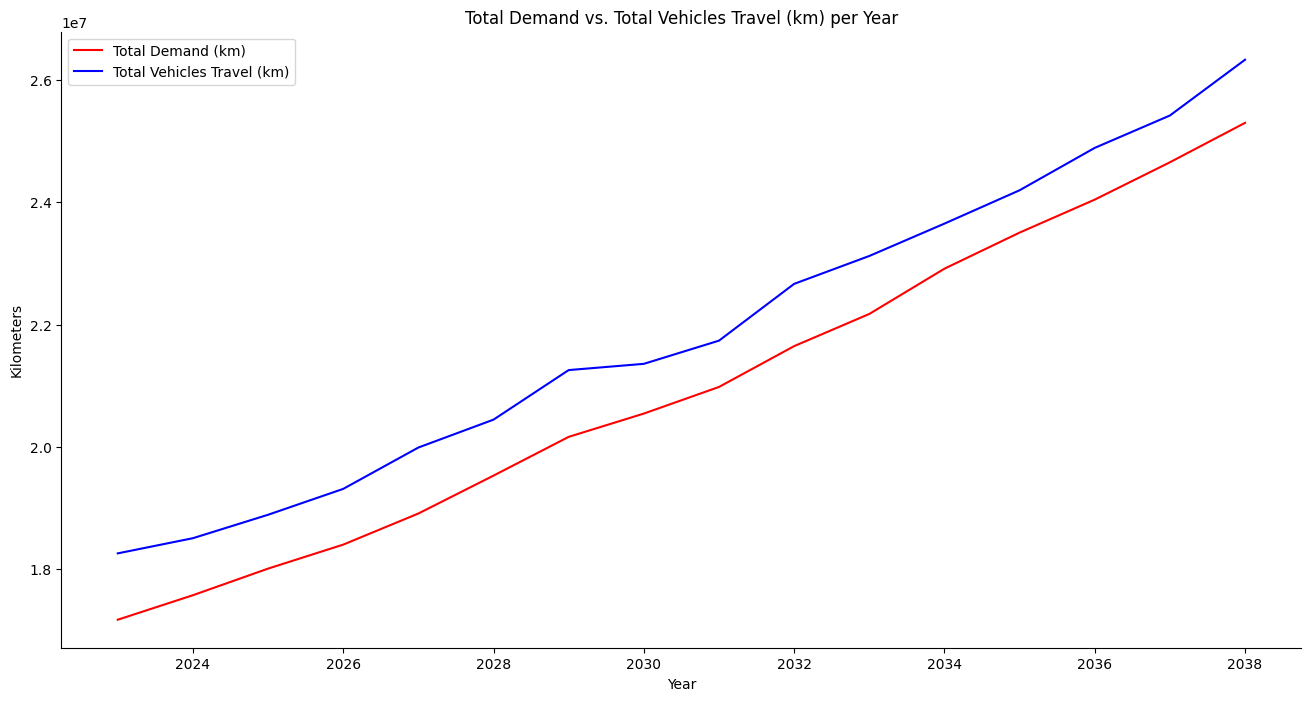

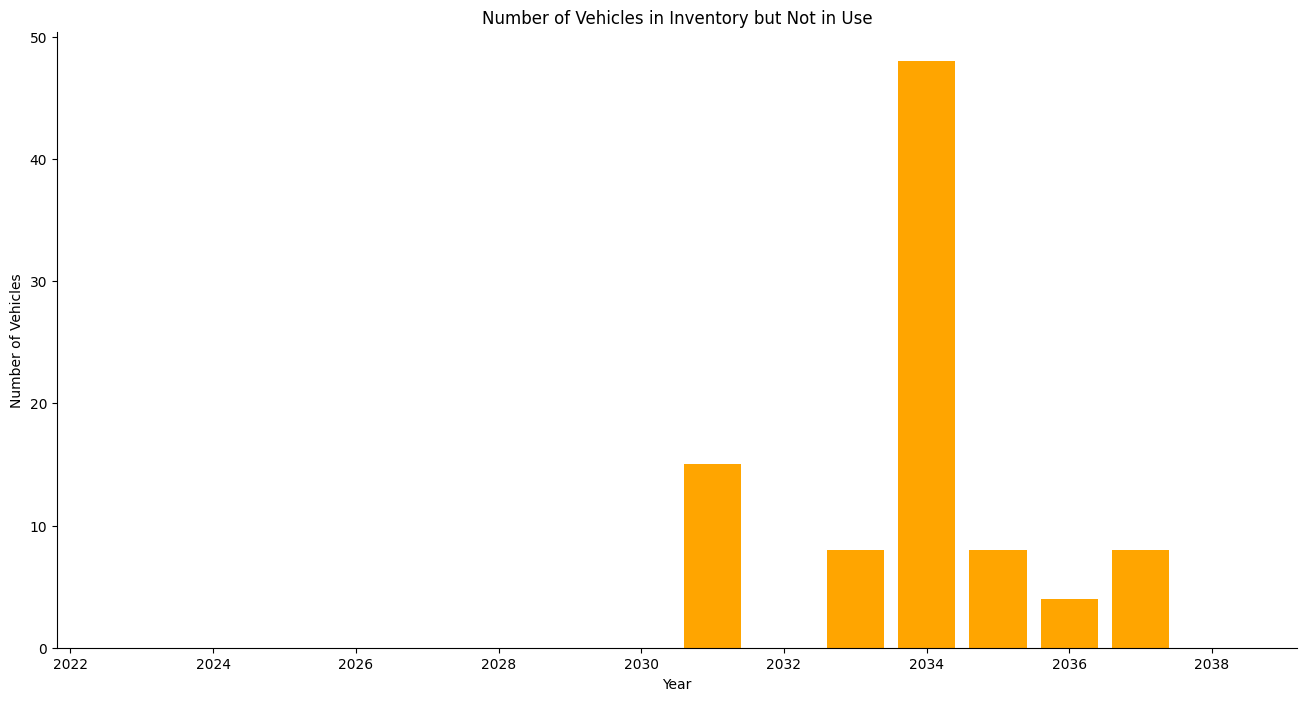

In [ ]:
# @title demand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Load the data
output_df = pd.read_csv('solution.csv')
demand_df = pd.read_csv('demand.csv')
vehicles_df = pd.read_csv('vehicles.csv')

def plot_demand_vs_travel(output_df, demand_df, vehicles_df):
    # Calculate total demand per year
    total_demand_per_year = demand_df.groupby('Year')['Demand (km)'].sum().reset_index()

    # Calculate total vehicles travel kilometers per year
    output_df['Total_Travel_Km'] = output_df['Num_Vehicles'] * output_df['Distance_per_vehicle(km)']
    total_travel_per_year = output_df[output_df['Type'] == 'Use'].groupby('Year')['Total_Travel_Km'].sum().reset_index()

    # Merge the demand and travel data
    comparison_df = pd.merge(total_demand_per_year, total_travel_per_year, on='Year', how='left').fillna(0)

    # Plot the data
    plt.figure(figsize=(16, 8))
    plt.plot(comparison_df['Year'], comparison_df['Demand (km)'], label='Total Demand (km)', color='red')
    plt.plot(comparison_df['Year'], comparison_df['Total_Travel_Km'], label='Total Vehicles Travel (km)', color='blue')
    plt.xlabel('Year')
    plt.ylabel('Kilometers')
    plt.title('Total Demand vs. Total Vehicles Travel (km) per Year')
    plt.legend()
    plt.grid(False)
    plt.show()

# Example usage with the provided file paths
plot_demand_vs_travel(output_df, demand_df, vehicles_df)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Load the data
output_df = pd.read_csv('solution.csv')
vehicles_df = pd.read_csv('vehicles.csv')

# Add 'Not in Use' column
def add_not_in_use(output_df, vehicles_df):
    output_df['Not in Use'] = 0
    inventory = {year: {} for year in range(2023, 2039)}
    next_year_sales = {year: {} for year in range(2023, 2039)}

    for year in range(2023, 2039):
        year_df = output_df[output_df['Year'] == year]

        for index, row in year_df.iterrows():
            vehicle_id = row['ID']
            num_vehicles = row['Num_Vehicles']
            action_type = row['Type']

            if action_type == 'Buy':
                if vehicle_id not in inventory[year]:
                    inventory[year][vehicle_id] = 0
                inventory[year][vehicle_id] += num_vehicles
            elif action_type == 'Sell':
                if vehicle_id in inventory[year]:
                    if vehicle_id not in next_year_sales[year]:
                        next_year_sales[year][vehicle_id] = 0
                    next_year_sales[year][vehicle_id] += num_vehicles
            elif action_type == 'Use':
                if vehicle_id in inventory[year]:
                    inventory[year][vehicle_id] -= num_vehicles

        if year < 2038:
            for vehicle_id, count in inventory[year].items():
                if count > 0:
                    if vehicle_id not in inventory[year + 1]:
                        inventory[year + 1][vehicle_id] = 0
                    inventory[year + 1][vehicle_id] += count

            for vehicle_id, count in next_year_sales[year].items():
                if count > 0:
                    if vehicle_id in inventory[year + 1]:
                        inventory[year + 1][vehicle_id] -= count

    for year in range(2023, 2039):
        not_in_use_count = 0
        for vehicle_id, count in inventory[year].items():
            not_in_use_count += max(count, 0)
        output_df.loc[(output_df['Year'] == year) & (output_df['Type'] == 'Buy'), 'Not in Use'] = not_in_use_count

    return output_df

# Function to plot the number of vehicles in the inventory but not in use
def plot_not_in_use_vehicles(file_path):
    # Read the solution CSV file
    df = pd.read_csv(file_path)
    df = add_not_in_use(df, vehicles_df)

    # Calculate total not in use vehicles per year
    not_in_use_per_year = df[df['Type'] == 'Buy'].groupby('Year')['Not in Use'].sum().reset_index()

    # Plot the data
    plt.figure(figsize=(16, 8))
    plt.bar(not_in_use_per_year['Year'], not_in_use_per_year['Not in Use'], color='orange')
    plt.xlabel('Year')
    plt.ylabel('Number of Vehicles')
    plt.title('Number of Vehicles in Inventory but Not in Use')
    plt.grid(False)
    plt.show()

# Example usage with the provided file path
plot_not_in_use_vehicles('solution.csv')

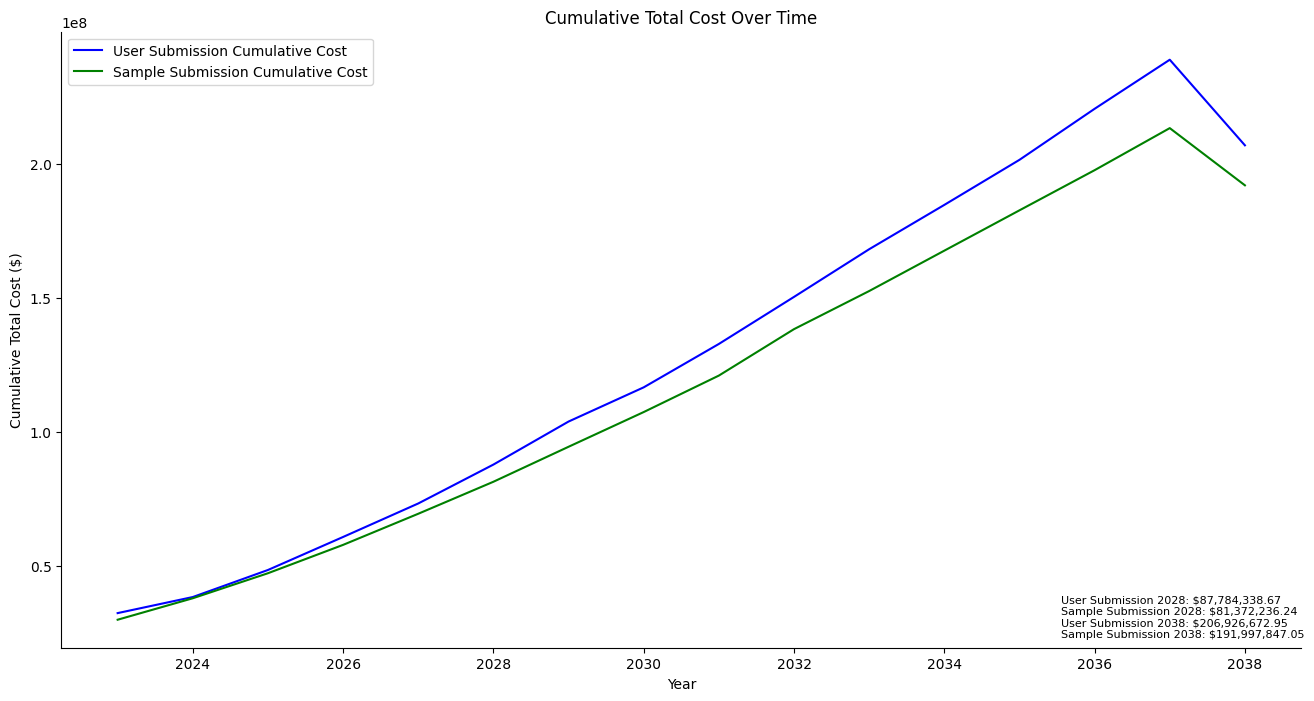

In [ ]:
# @title Total Cost Baselining
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Convert cost_profile_df to a dictionary
cost_profile_dict = {}
for _, row in cost_profile_df.iterrows():
    year = row['End of Year']
    cost_profile_dict[year] = {
        "resale_value": row['Resale Value %'] / 100,
        "insurance_cost": row['Insurance Cost %'] / 100,
        "maintenance_cost": row['Maintenance Cost %'] / 100
    }

def calculate_costs(output_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, start_year, end_year, sell_all = True):
    yearly_costs = {}
    total_cost = 0

    total_purchase_cost = 0
    total_resale_value = 0
    total_fuel_cost = 0
    total_fuel_cost_upper = 0
    total_fuel_cost_lower = 0
    total_insurance_cost = 0
    total_maintenance_cost = 0

    # Initialize a dictionary to track the inventory of vehicles each year
    fleet_inventory = {year: {} for year in range(start_year, end_year + 1)}

    for year in range(start_year, end_year + 1):
        yearly_costs[year] = {
            'purchase_cost': 0,
            'fuel_cost': 0,
            'fuel_cost_upper': 0,
            'fuel_cost_lower': 0,
            'insurance_cost': 0,
            'maintenance_cost': 0,
            'resale_value': 0
        }

    for _, row in output_df.iterrows():
        year = row['Year']
        if year < start_year or year > end_year:
            continue

        vehicle_id = row['ID']
        num_vehicles = row['Num_Vehicles']
        action_type = row['Type']
        fuel_type = row.get('Fuel', None)
        distance_bucket = row.get('Distance_bucket', None)
        distance_per_vehicle = row.get('Distance_per_vehicle(km)', 0)

        vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
        purchase_year = int(vehicle_id.split('_')[-1])

        if action_type == 'Buy':
            yearly_purchase_cost = vehicle_cost * num_vehicles
            yearly_costs[year]['purchase_cost'] += yearly_purchase_cost
            total_purchase_cost += yearly_purchase_cost
            total_cost += yearly_purchase_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles

        elif action_type == 'Use':
            fuel_consumption = vehicles_fuels_df[(vehicles_fuels_df['ID'] == vehicle_id) & (vehicles_fuels_df['Fuel'] == fuel_type)]['Consumption (unit_fuel/km)'].values[0]
            fuel_info = fuels_df[(fuels_df['Year'] == year) & (fuels_df['Fuel'] == fuel_type)]
            fuel_unit_cost = fuel_info['Cost ($/unit_fuel)'].values[0]
            fuel_uncertainty = fuel_info['Cost Uncertainty (±%)'].values[0] / 100

            yearly_fuel_cost = fuel_consumption * distance_per_vehicle * fuel_unit_cost * num_vehicles
            yearly_fuel_cost_upper = yearly_fuel_cost * (1 + fuel_uncertainty)
            yearly_fuel_cost_lower = yearly_fuel_cost * (1 - fuel_uncertainty)

            yearly_costs[year]['fuel_cost'] += yearly_fuel_cost
            yearly_costs[year]['fuel_cost_upper'] += yearly_fuel_cost_upper
            yearly_costs[year]['fuel_cost_lower'] += yearly_fuel_cost_lower
            total_fuel_cost += yearly_fuel_cost
            total_fuel_cost_upper += yearly_fuel_cost_upper
            total_fuel_cost_lower += yearly_fuel_cost_lower
            total_cost += yearly_fuel_cost #yearly_fuel_cost_upper*1.0426

            # age = year - purchase_year + 1
            # if 1 <= age <= 10:
            #   yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
            #   yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
            #   total_insurance_cost += yearly_insurance_cost
            #   total_cost += yearly_insurance_cost

            #   yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
            #   yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
            #   total_maintenance_cost += yearly_maintenance_cost
            #   total_cost += yearly_maintenance_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles


        if action_type == 'Sell':
            age = year - purchase_year + 1
            if age > 0:
                yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
                yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
                total_insurance_cost += yearly_insurance_cost
                total_cost += yearly_insurance_cost

                yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
                yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
                total_maintenance_cost += yearly_maintenance_cost
                total_cost += yearly_maintenance_cost

                resale_value = vehicle_cost * cost_profile_dict[min(age, 10)]['resale_value'] * num_vehicles
                yearly_costs[year]['resale_value'] += resale_value
                total_resale_value += resale_value
                total_cost -= resale_value

            # Update the fleet inventory for the year
            if vehicle_id in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] -= num_vehicles

    # Sell all remaining vehicles at the end of the final year
    if sell_all == True:
      final_year = end_year
      for vehicle_id, num_vehicles in fleet_inventory[final_year].items():
          if num_vehicles > 0:
              vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
              age = final_year - int(vehicle_id.split('_')[-1]) + 1
              resale_value = vehicle_cost * cost_profile_dict[min(age, 10)]['resale_value'] * num_vehicles
              yearly_costs[final_year]['resale_value'] += resale_value
              total_resale_value += resale_value
              total_cost -= resale_value

    # Calculate insurance and maintenance costs for all vehicles in the fleet
    for year in range(start_year, end_year+1):
        for vehicle_id, num_vehicles in fleet_inventory[year].items():
            if num_vehicles > 0:
                vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
                purchase_year = int(vehicle_id.split('_')[-1])
                age = year - purchase_year + 1
                if 1 <= age <= 10:
                    yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
                    yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
                    total_insurance_cost += yearly_insurance_cost
                    total_cost += yearly_insurance_cost

                    yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
                    yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
                    total_maintenance_cost += yearly_maintenance_cost
                    total_cost += yearly_maintenance_cost

    return yearly_costs, total_cost

def compare_cumulative_costs(solution_file, sample_file):
    # Load the solution and sample files
    solution_df = pd.read_csv(solution_file)
    sample_df = pd.read_csv(sample_file)

    # Calculate cumulative costs for the solution file
    solution_yearly_costs, _ = calculate_costs(solution_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, 2023, 2038)
    solution_cumulative_cost = []
    solution_running_total = 0
    for year in range(2023, 2039):
        solution_running_total += solution_yearly_costs[year]['purchase_cost'] + solution_yearly_costs[year]['fuel_cost'] + solution_yearly_costs[year]['insurance_cost'] + solution_yearly_costs[year]['maintenance_cost'] - solution_yearly_costs[year]['resale_value']
        solution_cumulative_cost.append(solution_running_total)

    # Calculate cumulative costs for the sample file
    sample_yearly_costs, _ = calculate_costs(sample_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, 2023, 2038)
    sample_cumulative_cost = []
    sample_running_total = 0
    for year in range(2023, 2039):
        sample_running_total += sample_yearly_costs[year]['purchase_cost'] + sample_yearly_costs[year]['fuel_cost'] + sample_yearly_costs[year]['insurance_cost'] + sample_yearly_costs[year]['maintenance_cost'] - sample_yearly_costs[year]['resale_value']
        sample_cumulative_cost.append(sample_running_total)

    # Create the plot
    plt.figure(figsize=(16, 8))
    plt.plot(range(2023, 2039), solution_cumulative_cost, label='User Submission Cumulative Cost', color='blue')
    plt.plot(range(2023, 2039), sample_cumulative_cost, label='Sample Submission Cumulative Cost', color='green')

    # Add text for the cumulative costs in 2028 and 2038
    textstr = '\n'.join((
                f'User Submission 2028: ${solution_cumulative_cost[2028-2023]:,.2f}',
        f'Sample Submission 2028: ${sample_cumulative_cost[2028-2023]:,.2f}',
                        f'User Submission 2038: ${solution_cumulative_cost[2038-2023]:,.2f}',
        f'Sample Submission 2038: ${sample_cumulative_cost[2038-2023]:,.2f}'
    ))

    # Add the text box to the bottom right corner
    plt.gcf().text(0.75, 0.12, textstr, fontsize=8, verticalalignment='bottom', horizontalalignment='left',
                   bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    plt.xlabel('Year')
    plt.ylabel('Cumulative Total Cost ($)')
    plt.title('Cumulative Total Cost Over Time')
    plt.legend()
    plt.grid(False)
    plt.show()

# Example usage with the provided file paths
compare_cumulative_costs('solution.csv', 'sample_submission.csv')

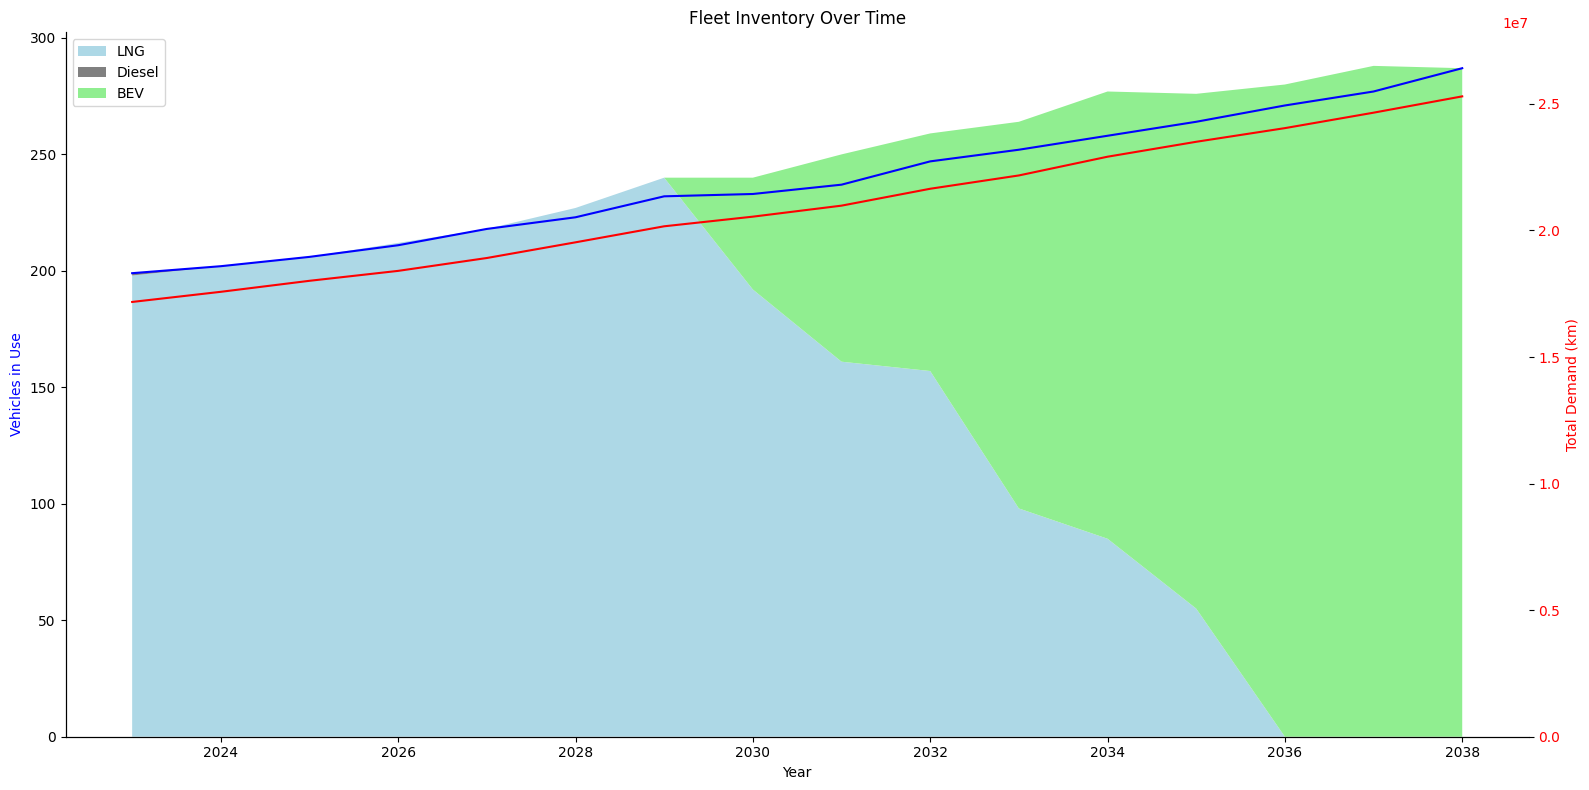

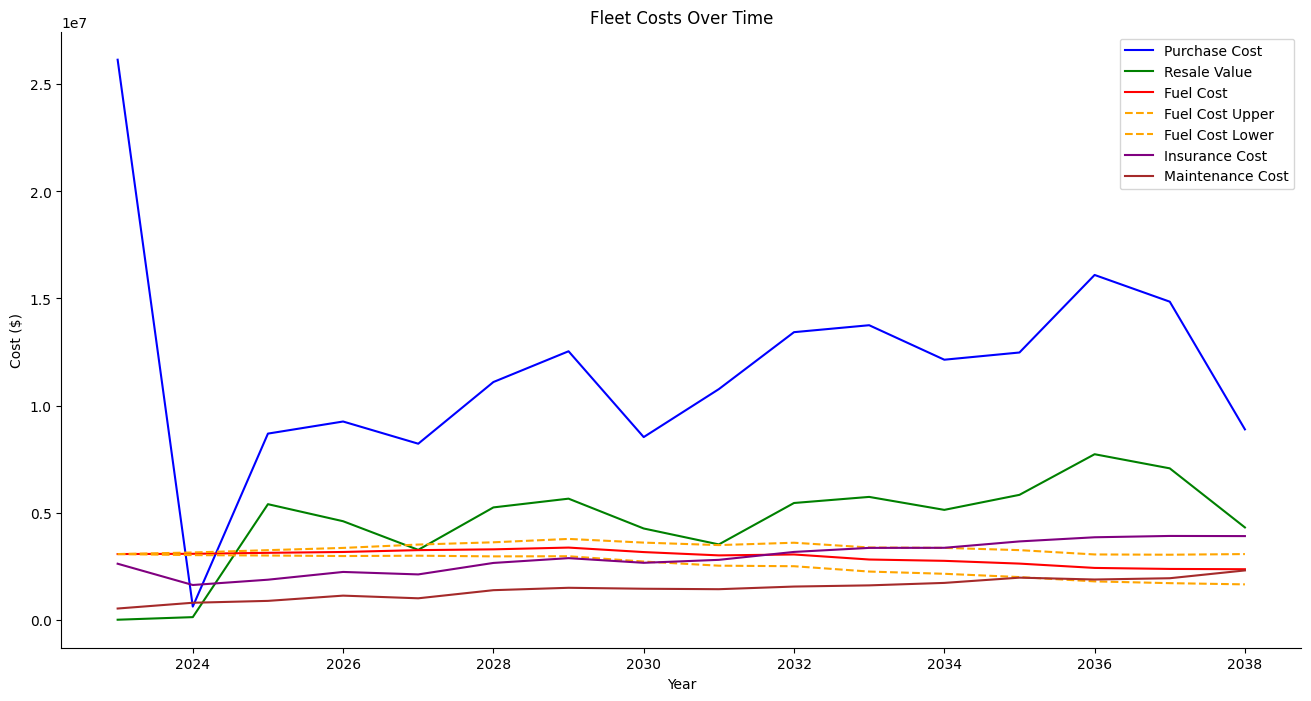

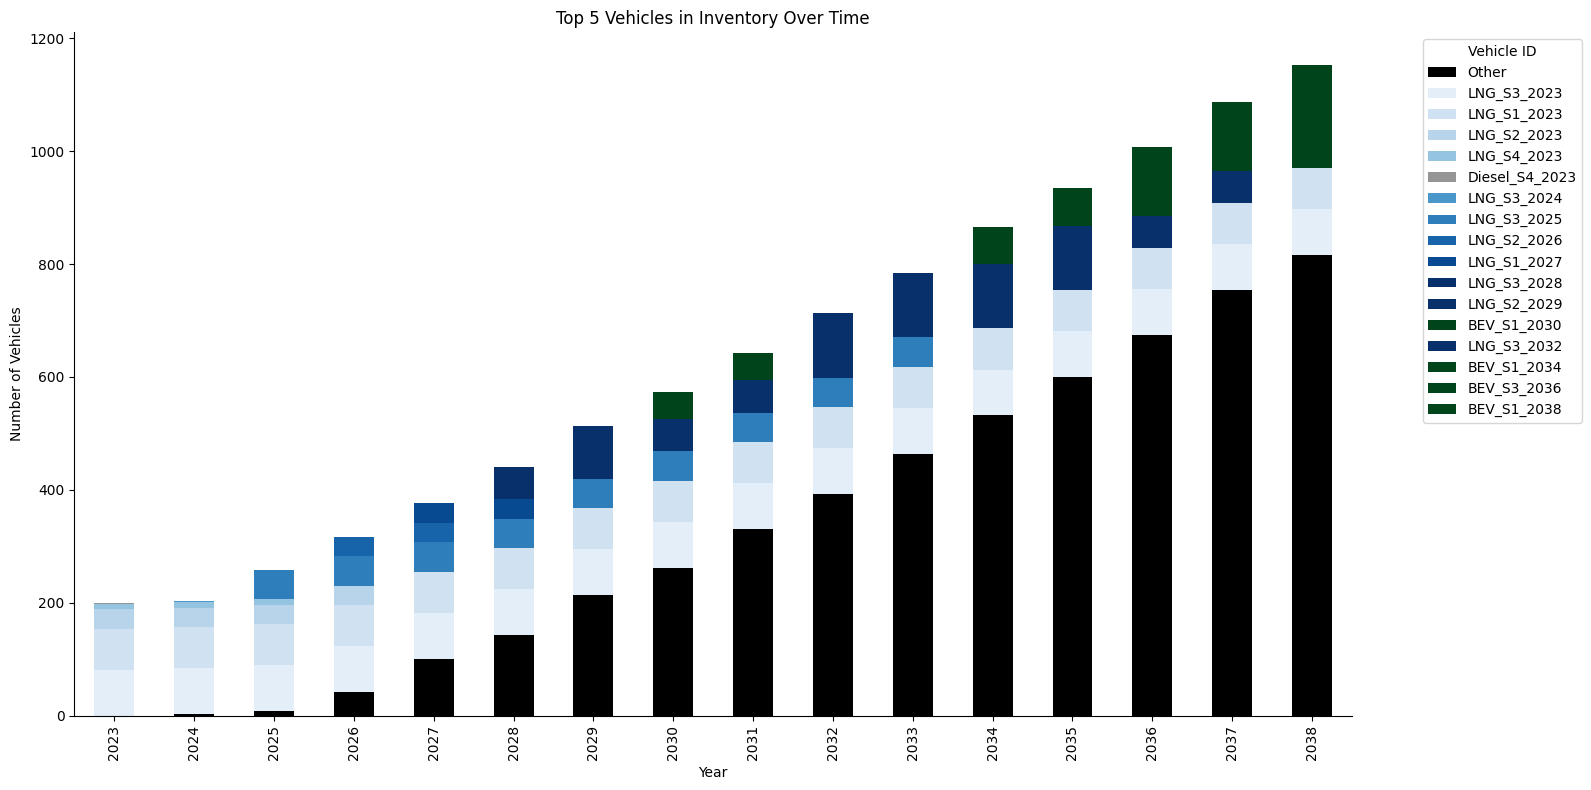

In [ ]:
# @title TRANSITION PLOTS
# file_path = 'sample_submission.csv' # @param {type:"string"}
file_path = "solution.csv" # @param ["solution.csv", "sample_submission.csv"]

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
output_df = pd.read_csv(file_path)
demand_df = pd.read_csv('demand.csv')
vehicles_df = pd.read_csv('vehicles.csv')
vehicles_fuels_df = pd.read_csv('vehicles_fuels.csv')
fuels_df = pd.read_csv('fuels.csv')
carbon_emissions_df = pd.read_csv('carbon_emissions.csv')
cost_profile_df = pd.read_csv('cost_profiles.csv')


# Function to plot fleet inventory over time considering vehicle sales
def plot_fleet_inventory_over_time(file_path):
    # Read the solution CSV file
    df = pd.read_csv(file_path)

    # Initialize a dictionary to store the count of each vehicle type over time
    inventory_counts = {'Year': [], 'LNG': [], 'Diesel': [], 'BEV': []}

    # Initialize counters for each vehicle type
    lng_count = 0
    diesel_count = 0
    bev_count = 0

    # Loop through each year
    for year in range(2023, 2039):
        # Filter the dataframe for the current year
        year_df = df[df['Year'] == year]

        # Update the counts based on purchases and sales
        for index, row in year_df.iterrows():
            if row['Type'] == 'Buy':
                if 'LNG' in row['ID']:
                    lng_count += row['Num_Vehicles']
                elif 'Diesel' in row['ID']:
                    diesel_count += row['Num_Vehicles']
                elif 'BEV' in row['ID']:
                    bev_count += row['Num_Vehicles']
            elif row['Type'] == 'Sell':
                if 'LNG' in row['ID']:
                    lng_count -= row['Num_Vehicles']
                elif 'Diesel' in row['ID']:
                    diesel_count -= row['Num_Vehicles']
                elif 'BEV' in row['ID']:
                    bev_count -= row['Num_Vehicles']

        # Append the counts to the inventory counts dictionary
        inventory_counts['Year'].append(year)
        inventory_counts['LNG'].append(lng_count)
        inventory_counts['Diesel'].append(diesel_count)
        inventory_counts['BEV'].append(bev_count)

    # Create a dataframe from the inventory counts
    inventory_df = pd.DataFrame(inventory_counts)

    # Calculate total demand per year
    total_demand_per_year = demand_df.groupby('Year')['Demand (km)'].sum().reset_index()

    # Calculate total vehicles in use per year
    vehicles_in_use_per_year = df[df['Type'] == 'Use'].groupby('Year')['Num_Vehicles'].sum().reset_index()

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Plot the fleet inventory data
    ax1.stackplot(inventory_df['Year'], inventory_df['LNG'], inventory_df['Diesel'], inventory_df['BEV'],
                  labels=['LNG', 'Diesel', 'BEV'], colors=['lightblue', 'grey', 'lightgreen'])

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Vehicles')
    ax1.set_title('Fleet Inventory Over Time')
    ax1.legend(loc='upper left')
    ax1.grid(False)

    # Create a secondary y-axis for the total demand
    ax2 = ax1.twinx()
    ax2.plot(total_demand_per_year['Year'], total_demand_per_year['Demand (km)'], color='red', label='Total Demand (km)')
    ax2.set_ylabel('Total Demand (km)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, max(total_demand_per_year['Demand (km)']) * 1.1)  # Set the limit to start from 0

    # Create a third y-axis for the vehicles in use
    # ax1.spines['right'].set_position(('outward', 60))
    ax1.plot(vehicles_in_use_per_year['Year'], vehicles_in_use_per_year['Num_Vehicles'], color='blue', label='Vehicles in Use')
    ax1.set_ylabel('Vehicles in Use', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax3.set_ylim(0, max(vehicles_in_use_per_year['Num_Vehicles']) * 1.1)  # Set the limit to start from 0

    fig.tight_layout()  # Adjust layout to make room for the extra y-axis
    plt.show()

plot_fleet_inventory_over_time(file_path)


import pandas as pd
import matplotlib.pyplot as plt

# Convert cost_profile_df to a dictionary
cost_profile_dict = {}
for _, row in cost_profile_df.iterrows():
    year = row['End of Year']
    cost_profile_dict[year] = {
        "resale_value": row['Resale Value %'] / 100,
        "insurance_cost": row['Insurance Cost %'] / 100,
        "maintenance_cost": row['Maintenance Cost %'] / 100
    }

def calculate_costs(output_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile, start_year, end_year):
    yearly_costs = {}
    total_cost = 0

    total_purchase_cost = 0
    total_resale_value = 0
    total_fuel_cost = 0
    total_fuel_cost_upper = 0
    total_fuel_cost_lower = 0
    total_insurance_cost = 0
    total_maintenance_cost = 0

    # Initialize a dictionary to track the inventory of vehicles each year
    fleet_inventory = {year: {} for year in range(start_year, end_year + 1)}

    for year in range(start_year, end_year + 1):
        yearly_costs[year] = {
            'purchase_cost': 0,
            'fuel_cost': 0,
            'fuel_cost_upper': 0,
            'fuel_cost_lower': 0,
            'insurance_cost': 0,
            'maintenance_cost': 0,
            'resale_value': 0
        }

    for _, row in output_df.iterrows():
        year = row['Year']
        if year < start_year or year > end_year:
            continue

        vehicle_id = row['ID']
        num_vehicles = row['Num_Vehicles']
        action_type = row['Type']
        fuel_type = row.get('Fuel', None)
        distance_bucket = row.get('Distance_bucket', None)
        distance_per_vehicle = row.get('Distance_per_vehicle(km)', 0)

        vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
        purchase_year = int(vehicle_id.split('_')[-1])

        if action_type == 'Buy':
            yearly_purchase_cost = vehicle_cost * num_vehicles
            yearly_costs[year]['purchase_cost'] += yearly_purchase_cost
            total_purchase_cost += yearly_purchase_cost
            total_cost += yearly_purchase_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles

        elif action_type == 'Sell':
            age = year - purchase_year + 1
            if age > 0:
                resale_value = vehicle_cost * cost_profile_dict[min(age, 10)]['resale_value'] * num_vehicles
                yearly_costs[year]['resale_value'] += resale_value
                total_resale_value += resale_value
                total_cost -= resale_value

            # Update the fleet inventory for the year
            if vehicle_id in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] -= num_vehicles

        elif action_type == 'Use':
            fuel_consumption = vehicles_fuels_df[(vehicles_fuels_df['ID'] == vehicle_id) & (vehicles_fuels_df['Fuel'] == fuel_type)]['Consumption (unit_fuel/km)'].values[0]
            fuel_info = fuels_df[(fuels_df['Year'] == year) & (fuels_df['Fuel'] == fuel_type)]
            fuel_unit_cost = fuel_info['Cost ($/unit_fuel)'].values[0]
            fuel_uncertainty = fuel_info['Cost Uncertainty (±%)'].values[0] / 100

            yearly_fuel_cost = fuel_consumption * distance_per_vehicle * fuel_unit_cost * num_vehicles
            yearly_fuel_cost_upper = yearly_fuel_cost * (1 + fuel_uncertainty)
            yearly_fuel_cost_lower = yearly_fuel_cost * (1 - fuel_uncertainty)

            yearly_costs[year]['fuel_cost'] += yearly_fuel_cost
            yearly_costs[year]['fuel_cost_upper'] += yearly_fuel_cost_upper
            yearly_costs[year]['fuel_cost_lower'] += yearly_fuel_cost_lower
            total_fuel_cost += yearly_fuel_cost
            total_fuel_cost_upper += yearly_fuel_cost_upper
            total_fuel_cost_lower += yearly_fuel_cost_lower
            total_cost += yearly_fuel_cost

            # Update the fleet inventory for the year
            if vehicle_id not in fleet_inventory[year]:
                fleet_inventory[year][vehicle_id] = 0
            fleet_inventory[year][vehicle_id] += num_vehicles

    # Calculate insurance and maintenance costs for all vehicles in the fleet
    for year in range(start_year, end_year + 1):
        for vehicle_id, num_vehicles in fleet_inventory[year].items():
            if num_vehicles > 0:
                vehicle_cost = vehicles_df[vehicles_df['ID'] == vehicle_id]['Cost ($)'].values[0]
                purchase_year = int(vehicle_id.split('_')[-1])
                age = year - purchase_year + 1
                if 1 <= age <= 10:
                    yearly_insurance_cost = vehicle_cost * cost_profile_dict[age]['insurance_cost'] * num_vehicles
                    yearly_costs[year]['insurance_cost'] += yearly_insurance_cost
                    total_insurance_cost += yearly_insurance_cost
                    total_cost += yearly_insurance_cost

                    yearly_maintenance_cost = vehicle_cost * cost_profile_dict[age]['maintenance_cost'] * num_vehicles
                    yearly_costs[year]['maintenance_cost'] += yearly_maintenance_cost
                    total_maintenance_cost += yearly_maintenance_cost
                    total_cost += yearly_maintenance_cost

    return yearly_costs

# Function to plot the costs over time
def plot_costs_over_time(file_path):
    yearly_costs = calculate_costs(output_df, vehicles_df, vehicles_fuels_df, fuels_df, cost_profile_dict, 2023, 2038)

    # Convert yearly_costs to a DataFrame for plotting
    costs_df = pd.DataFrame.from_dict(yearly_costs, orient='index')

    # Plot the data
    plt.figure(figsize=(16, 8))
    plt.plot(costs_df.index, costs_df['purchase_cost'], label='Purchase Cost', color='blue')
    plt.plot(costs_df.index, costs_df['resale_value'], label='Resale Value', color='green')
    plt.plot(costs_df.index, costs_df['fuel_cost'], label='Fuel Cost', color='red')
    plt.plot(costs_df.index, costs_df['fuel_cost_upper'], label='Fuel Cost Upper', color='orange', linestyle='--')
    plt.plot(costs_df.index, costs_df['fuel_cost_lower'], label='Fuel Cost Lower', color='orange', linestyle='--')
    plt.plot(costs_df.index, costs_df['insurance_cost'], label='Insurance Cost', color='purple')
    plt.plot(costs_df.index, costs_df['maintenance_cost'], label='Maintenance Cost', color='brown')

    plt.xlabel('Year')
    plt.ylabel('Cost ($)')
    plt.title('Fleet Costs Over Time')
    plt.legend()
    plt.grid(False)
    plt.show()

# Example usage with the provided file path
plot_costs_over_time(file_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define colors for vehicle types
color_map = {
    'LNG': plt.cm.Blues,
    'Diesel': plt.cm.Greys,
    'BEV': plt.cm.Greens
}

# Function to get the color for a vehicle ID
def get_vehicle_color(vehicle_id, index):
    if 'LNG' in vehicle_id:
        return color_map['LNG'](index / 10)
    elif 'Diesel' in vehicle_id:
        return color_map['Diesel'](index / 10)
    elif 'BEV' in vehicle_id:
        return color_map['BEV'](index / 10)
    return 'black'

# Function to plot top 5 vehicles over time
def plot_top_vehicles_over_time(file_path):
    # Read the solution CSV file
    df = pd.read_csv(file_path)

    # Initialize a dictionary to track the inventory of vehicles each year
    inventory_counts = {year: {} for year in range(2023, 2039)}

    # Loop through each year to update inventory based on purchases and sales
    for year in range(2023, 2039):
        year_df = df[df['Year'] == year]

        for index, row in year_df.iterrows():
            vehicle_id = row['ID']
            num_vehicles = row['Num_Vehicles']
            action_type = row['Type']

            if action_type == 'Buy':
                if vehicle_id not in inventory_counts[year]:
                    inventory_counts[year][vehicle_id] = 0
                inventory_counts[year][vehicle_id] += num_vehicles
            elif action_type == 'Sell':
                if vehicle_id in inventory_counts[year]:
                    inventory_counts[year][vehicle_id] -= num_vehicles

        # Carry forward the inventory from the previous year
        if year > 2023:
            for vehicle_id, count in inventory_counts[year - 1].items():
                if vehicle_id not in inventory_counts[year]:
                    inventory_counts[year][vehicle_id] = 0
                inventory_counts[year][vehicle_id] += count

    # Prepare data for plotting
    plot_data = {year: {'Other': 0} for year in range(2023, 2039)}

    for year in range(2023, 2039):
        sorted_vehicles = sorted(inventory_counts[year].items(), key=lambda item: item[1], reverse=True)
        top_5_vehicles = sorted_vehicles[:5]
        other_vehicles_count = sum(count for _, count in sorted_vehicles[5:])

        for vehicle_id, count in top_5_vehicles:
            plot_data[year][vehicle_id] = count
        plot_data[year]['Other'] += other_vehicles_count

    # Convert the plot data to a DataFrame
    plot_df = pd.DataFrame(plot_data).T.fillna(0)

    # Create a color list for the bars
    colors = []
    for i, vehicle_id in enumerate(plot_df.columns):
        if vehicle_id != 'Other':
            colors.append(get_vehicle_color(vehicle_id, i))
        else:
            colors.append('black')

    # Plot the data with specified colors
    ax = plot_df.plot(kind='bar', stacked=True, figsize=(16, 8), color=colors)
    plt.xlabel('Year')
    plt.ylabel('Number of Vehicles')
    plt.title('Top 5 Vehicles in Inventory Over Time')
    plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage with the provided file path
plot_top_vehicles_over_time(file_path)

In [ ]:
# @title ERROR 15

def validate_distance_buckets(output_df, vehicles_df):
    # Create a dictionary to map vehicle IDs to their distance buckets
    vehicle_distance_buckets = dict(zip(vehicles_df['ID'], vehicles_df['Distance']))

    # Create a dictionary to map distance bucket strings to their hierarchy level
    distance_hierarchy = {'D1': 1, 'D2': 2, 'D3': 3, 'D4': 4}

    # Iterate over each row in the output dataframe
    for index, row in output_df.iterrows():
        vehicle_id = row['ID']
        distance_bucket = row['Distance_bucket']
        record_type = row['Type']

        # Only validate distance buckets for "Use" records
        if record_type != "Use":
            continue

        if vehicle_id not in vehicle_distance_buckets:
            print(f"Vehicle ID {vehicle_id} not found in vehicles dataframe.")
            continue

        vehicle_distance = vehicle_distance_buckets[vehicle_id]

        # Check if the vehicle's distance bucket can satisfy the demand
        if distance_hierarchy[vehicle_distance] < distance_hierarchy[distance_bucket]:
            print(f"Vehicle {vehicle_id} in distance bucket {vehicle_distance} cannot satisfy demand in distance bucket {distance_bucket}.")
            return False

    print("All distance bucket constraints are obeyed.")
    return True

# Usage
validate_distance_buckets(output_df, vehicles_df)

All distance bucket constraints are obeyed.


True

In [ ]:
# @title ERROR 16
def validate_vehicle_purchase_year(output_df):
    """
    Validate if each vehicle bought in a given year has the correct year in its ID.

    Parameters:
    output_df (pd.DataFrame): The output dataframe containing the fleet operations.

    Returns:
    bool: True if all purchases are valid, False otherwise.
    """
    for index, row in output_df.iterrows():
        if row['Type'] == 'Buy':
            purchase_year = row['Year']
            vehicle_id_year = int(row['ID'].split('_')[-1])
            if purchase_year != vehicle_id_year:
                print(f"Validation failed: Vehicle {row['ID']} bought in year {purchase_year} but should be bought in year {vehicle_id_year}.")

    return True

# Usage
validate_vehicle_purchase_year(output_df)

True

In [ ]:
# @title ERROR 17

import pandas as pd

def check_vehicle_usage_and_inventory(output_df):
    # Parse the year from the vehicle ID
    def get_year_from_id(vehicle_id):
        return int(vehicle_id.split('_')[-1])

    # Initialize a dictionary to track vehicle usage and inventory by ID and year
    vehicle_usage = {}
    vehicle_inventory = {}

    # Iterate over each row in the output dataframe
    for index, row in output_df.iterrows():
        vehicle_id = row['ID']
        year = row['Year']
        type_action = row['Type']
        num_vehicles = row['Num_Vehicles']

        if vehicle_id not in vehicle_usage:
            vehicle_usage[vehicle_id] = {'purchased': get_year_from_id(vehicle_id), 'used_years': set()}
            vehicle_inventory[vehicle_id] = {}

        if year not in vehicle_inventory[vehicle_id]:
            vehicle_inventory[vehicle_id][year] = 0

        if type_action == 'Use':
            if year > vehicle_usage[vehicle_id]['purchased'] + 9:
                print(f"Validation failed: Vehicle {vehicle_id} used in year {year} but should not be used after year {vehicle_usage[vehicle_id]['purchased'] + 9}.")
            vehicle_usage[vehicle_id]['used_years'].add(year)
            vehicle_inventory[vehicle_id][year] -= num_vehicles

        if type_action == 'Buy':
            vehicle_inventory[vehicle_id][year] += num_vehicles

        if type_action == 'Sell':
            vehicle_inventory[vehicle_id][year] -= num_vehicles

    # Check for inventory compliance
    for vehicle_id, data in vehicle_usage.items():
        purchase_year = data['purchased']
        for used_year in data['used_years']:
            if used_year > purchase_year + 9:
                print(f"Validation failed: Vehicle {vehicle_id} used in year {used_year} but should not be used after year {purchase_year + 9}.")

    # Check for vehicles sitting in inventory unused for more than 10 years each year
    for vehicle_id, inventory_data in vehicle_inventory.items():
        for year, inventory in inventory_data.items():
            if inventory > 0:
                if year > vehicle_usage[vehicle_id]['purchased'] + 9:
                    print(f"Validation failed: Vehicle {vehicle_id} has {inventory} units sitting in inventory in year {year}, which is more than 10 years since purchase year {vehicle_usage[vehicle_id]['purchased']}.")

check_vehicle_usage_and_inventory(output_df)

# Parse the year from the vehicle ID
def get_year_from_id(vehicle_id):
    return int(vehicle_id.split('_')[-1])

# Initialize dictionaries to track usage and inventory
usage_violations = []
inventory_violations = []
inventory_tracking = {}

# Iterate over each row in the output dataframe
for index, row in output_df.iterrows():
    vehicle_id = row['ID']
    year = row['Year']
    type_action = row['Type']
    num_vehicles = row['Num_Vehicles']
    purchase_year = get_year_from_id(vehicle_id)

    if vehicle_id not in inventory_tracking:
        inventory_tracking[vehicle_id] = {}

    if type_action == 'Use':
        if year > purchase_year + 9:
            usage_violations.append((vehicle_id, year, purchase_year))

    if year not in inventory_tracking[vehicle_id]:
        inventory_tracking[vehicle_id][year] = 0

    if type_action == 'Buy':
        for y in range(year, 2039):  # Track inventory until 2038
            if y not in inventory_tracking[vehicle_id]:
                inventory_tracking[vehicle_id][y] = 0
            inventory_tracking[vehicle_id][y] += num_vehicles

    if type_action == 'Sell':
        for y in range(year, 2039):
            if y not in inventory_tracking[vehicle_id]:
                inventory_tracking[vehicle_id][y] = 0
            inventory_tracking[vehicle_id][y] -= num_vehicles

# Check for inventory violations
for vehicle_id, years in inventory_tracking.items():
    purchase_year = get_year_from_id(vehicle_id)
    for year, inventory in years.items():
        if inventory > 0 and year > purchase_year + 9:
            inventory_violations.append((vehicle_id, year, purchase_year, inventory))

# Print out violations
if usage_violations:
    print("Usage violations:")
    for v in usage_violations:
        print(f"Vehicle {v[0]} used in year {v[1]} but should not be used after year {v[2] + 9}.")

if inventory_violations:
    print("Inventory violations:")
    for v in inventory_violations:
        print(f"Vehicle {v[0]} has {v[3]} units sitting in inventory in year {v[1]}, which is more than 10 years since purchase year {v[2]}.")

if not usage_violations and not inventory_violations:
    print("No violations found.")

No violations found.


In [ ]:
# @title ERROR 18 & 19
def check_demand_satisfaction(demand_df, solution_df):
    # Initialize a dictionary to store the total distance traveled per size-distance bucket per year
    traveled_distances = {}

    for _, row in solution_df.iterrows():
        if row['Type'] == 'Use':
            year = row['Year']
            size = row['ID'].split('_')[1]  # Extracting size from ID
            distance_bucket = row['Distance_bucket']
            num_vehicles = row['Num_Vehicles']
            distance_per_vehicle = row['Distance_per_vehicle(km)']

            if (year, size, distance_bucket) not in traveled_distances:
                traveled_distances[(year, size, distance_bucket)] = 0

            traveled_distances[(year, size, distance_bucket)] += num_vehicles * distance_per_vehicle

    # Initialize a list to store any issues found
    issues = []

    # Iterate over the demand dataframe to check if each size-distance bucket is satisfied
    for _, row in demand_df.iterrows():
        year = row['Year']
        size = row['Size']
        distance_bucket = row['Distance']
        demand = row['Demand (km)']

        if (year, size, distance_bucket) not in traveled_distances:
            issues.append(f"Year {year}, Size {size}, Distance {distance_bucket}: No vehicles used to satisfy the demand")
        elif traveled_distances[(year, size, distance_bucket)] < demand:
            issues.append(f"Year {year}, Size {size}, Distance {distance_bucket}: Demand not satisfied. Required {demand}, traveled {traveled_distances[(year, size, distance_bucket)]}")

    # Print the issues or indicate that all demands are satisfied
    if issues:
        for issue in issues:
            print(issue)
    else:
        print("All demands are satisfied for every size-distance bucket per year.")

check_demand_satisfaction(demand_df, output_df)

All demands are satisfied for every size-distance bucket per year.


In [ ]:
# @title ERROR 21
import pandas as pd

def check_sell_limit(output_df):
    # Initialize a dictionary to store the inventory by year
    yearly_inventory = {}

    # Track overall inventory across years
    overall_inventory = 0

    # Process the data to track inventory changes year over year
    for year in range(2023, 2039):
        yearly_inventory[year] = {'bought': 0, 'sold': 0, 'inventory_start': overall_inventory, 'inventory_end': overall_inventory}

    for _, row in output_df.iterrows():
        year = row['Year']
        num_vehicles = row['Num_Vehicles']
        action_type = row['Type']

        if action_type == 'Buy':
            yearly_inventory[year]['bought'] += num_vehicles
            overall_inventory += num_vehicles

        elif action_type == 'Sell':
            yearly_inventory[year]['sold'] += num_vehicles
            overall_inventory -= num_vehicles

    # Update inventory start and end for each year
    for year in range(2023, 2039):
        if year == 2023:
            yearly_inventory[year]['inventory_start'] = yearly_inventory[year]['inventory_end']
            yearly_inventory[year]['inventory_end'] += yearly_inventory[year]['bought'] - yearly_inventory[year]['sold']
        else:
            yearly_inventory[year]['inventory_start'] = yearly_inventory[year-1]['inventory_end'] + yearly_inventory[year]['bought']
            yearly_inventory[year]['inventory_end'] = yearly_inventory[year]['inventory_start'] - yearly_inventory[year]['sold']

    # Check the sell limit constraint and print inventory status
    issues = []

    for year, data in yearly_inventory.items():
        inventory_start = data['inventory_start']
        inventory_end = data['inventory_end']
        sold = data['sold']

        # print(f"Year {year}:")
        # print(f"  Inventory at the start of the year: {inventory_start}")
        # print(f"  Inventory at the end of the year: {inventory_end}")
        # print(f"  Number of vehicles sold: {sold}")
        # print(f"  Allowed number of vehicles to sell (20% of starting inventory): {0.2 * inventory_start:.1f}")

        if sold > 0.2 * inventory_start:
            issues.append(f" Year {year}: Violation: Sold {sold} vehicles, which is more than 20% of the starting inventory {inventory_start}")

    # Print any issues found
    if issues:
        for issue in issues:
            print(issue)
    else:
        print("All sell limits are satisfied for every year.")

check_sell_limit(output_df)

All sell limits are satisfied for every year.
